# **The 'Neural' Network**

*MRI brain tumor diagnosis with machine learning*


---



The human brain is a beautiful meshwork of bioelectricity with which we contemplate reality. We'd like to keep it safe. We do so with a marvelous feat of electromagnetism: Magnetic Resonance Imaging. This project harnesses a convolutional neural network (CNN) to make a diagnosis from a MRI result (ubiquitous in cancer diagnosis). The premise is simple: upon receiving a brain scan, the network ascertains whether the patient is ailed by an intercranial tumor.

In [ ]:
import numpy as np
import jax.numpy as jnp
from jax import jit
import  jax
import matplotlib.pyplot as plt
import math
from matplotlib.animation import FuncAnimation
import itertools
from IPython.display import HTML
import os
import datetime;datetime.datetime.now()
from PIL import Image

In [ ]:
!unzip '/content/brain_tumor_dataset.zip'

Archive:  /content/brain_tumor_dataset.zip
replace brain_tumor_dataset/notumor_test/no 100.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Importing and compiling the MRI scan dataset into numpy arrays.
Dataset obtained from a kind user on [Kaggle](https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection)


I've split the scans into unique testing and training sets to avoid overfitting (cheating). Herein lie some sample scans with & without tumors to see what the sets look like


Text(0.5, 1.0, 'Non-cancerous')

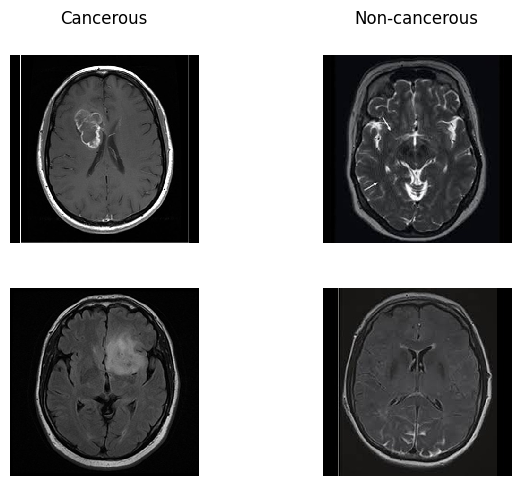

In [ ]:
tumor_train = []
notumor_train = []
tumor_test = []
notumor_test = []

for image in os.listdir('/content/brain_tumor_dataset/tumor_train'):
  img = os.path.join('/content/brain_tumor_dataset/tumor_train', image)
  tumor_train.append(np.asarray(Image.open(img)))

for image in os.listdir('/content/brain_tumor_dataset/notumor_train'):
  img = os.path.join('/content/brain_tumor_dataset/notumor_train', image)
  notumor_train.append(np.asarray(Image.open(img)))

for image in os.listdir('/content/brain_tumor_dataset/tumor_test'):
  img = os.path.join('/content/brain_tumor_dataset/tumor_test', image)
  tumor_test.append(np.asarray(Image.open(img)))

for image in os.listdir('/content/brain_tumor_dataset/notumor_test'):
  img = os.path.join('/content/brain_tumor_dataset/notumor_test', image)
  notumor_test.append(np.asarray(Image.open(img)))



fig, axs = plt.subplots(2, 2)
fig.tight_layout()

axs[0,0].matshow(tumor_train[0])
axs[0,0].axis('off')

axs[0,1].matshow(notumor_train[0])
axs[0,1].axis('off')

axs[1,0].matshow(tumor_test[1])
axs[1,0].axis('off')

axs[1,1].matshow(notumor_test[0])
axs[1,1].axis('off')

axs[0, 0].set_title("Cancerous")
axs[0, 1].set_title("Non-cancerous")


# Constructing training & testing datasets
I combined the positive & negative MRI scans and shuffled them in synchrony with their respective labels to prepare for training

[ 0 , 1 ] ~ positive result (tumor detected)

[ 1 , 0 ] ~  negative result (no tumor detected)


First element of training set BEFORE shuffle


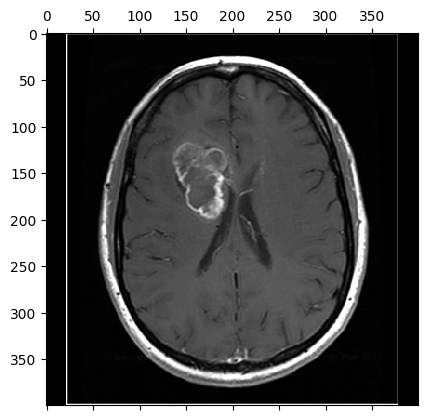

First element of training set AFTER shuffle


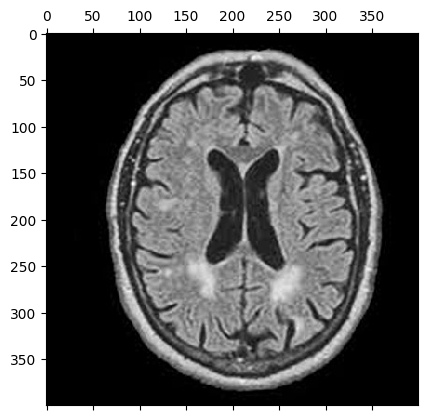

Shuffled test label set:
[1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1.
 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1.
 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0.]


In [ ]:
tumor_train = np.array(tumor_train)
notumor_train = np.array(notumor_train)
tumor_test = np.array(tumor_test)
notumor_test = np.array(notumor_test)

tumor_trainlabels = np.ones(len(tumor_train))
notumor_trainlabels = np.zeros(len(notumor_train))
tumor_testlabels = np.ones(len(tumor_test))
notumor_testlabels = np.zeros(len(notumor_test))

training_set = np.concatenate((tumor_train,notumor_train))
training_labels = np.concatenate((tumor_trainlabels,notumor_trainlabels))


print("===============================================")
print("First element of training set BEFORE shuffle")
print("===============================================")
plt.matshow(training_set[0])
plt.show()

#shuffles the images and labels in unison
def synergy_shuffle(a, b):
  assert len(a) == len(b)
  i = np.random.permutation(len(a))
  return a[i], b[i]

training_set, training_labels = synergy_shuffle(training_set, training_labels)

print("===============================================")
print("First element of training set AFTER shuffle")
print("===============================================")
plt.matshow(training_set[0])
plt.show()

test_set = np.concatenate((tumor_test,notumor_test))





test_labels = np.concatenate((tumor_testlabels,notumor_testlabels))

test_set, test_labels = synergy_shuffle(test_set,test_labels)
print("===============================================")
print("Shuffled test label set:")
print(test_labels)

In [ ]:
training_labels = training_labels.tolist()

In [ ]:
test_labels = test_labels.tolist()

In [ ]:
#structuring the label array as vectors
for i in range(0,len(training_labels)):
  if (training_labels[i] == 0):
    training_labels[i] = np.array([1,0])
  elif (training_labels[i] == 1):
    training_labels[i] = np.array([0,1])

for i in range(0,len(test_labels)):
  if (test_labels[i] == 0):
    test_labels[i] = np.array([1,0])
  elif (test_labels[i] == 1):
    test_labels[i] = np.array([0,1])

# **Neurogenesis: Creating the machine learning algorithm!**

I commence by reshaping our 3-channel 400x400 MRI scan into a normalized (dividing pixels by 256), flattened vector. The algorithm is an adaptation of the equation utlized in the PHYS 246 Machine Learning Galaxies project:

$$v_{out} = 1.0/(1+\exp(-(W_2 \textrm{tanh}(W_1 v_{in} + b_1) +b_2))$$

The parameters W1 & W2 are randomly generated weight matrices. Each connection between neurons is assigned a 'weight' by the rows of these matrices(analogous to neuroplastic synapse strengtheing!)

The parameters b1 & b2 are bias vectors which imbue flexibility by applying offset to neuronal input.

The careful manipulation of these weights and biases will be integral to converge onto the desired diagnosis accuracy


In [ ]:
training_set = training_set.reshape(len(training_set),400*400*3)/256.
test_set  = test_set.reshape(len(test_set),400*400*3)/256.



def neuralneural_network(params, imageVector):
   W1=params[0]
   b1=params[1]
   W2= params[2]
   b2 = params[3]
   v_in = imageVector
   v_out = 1/(1+jnp.exp(-(jnp.dot(W2,jnp.tanh(jnp.dot(W1,v_in) + b1)) +b2)))
   return v_out

neurons = 100
image_vector_size = 400*400*3
output_size = 2 #2 possibilities
params = [0,0,0,0]
params[0] = 0.1*np.random.randn(neurons, image_vector_size)
params[1] = 0.1*np.random.randn(neurons)
params[2] = 0.1*np.random.randn(output_size,neurons)
params[3] = 0.1*np.random.randn(output_size)

guess = neuralneural_network(params, training_set[5])

print("The initial state of our diagnosis is:")
print(guess)
print("Results are currently a blend of positive and negative; this will be rectified shortly")


The initial state of our diagnosis is:
[0.34990025 0.3833307 ]
Results are currently a blend of positive and negative; this will be rectified shortly


# **The Second Law of Information Dynamics: Cross-entropy!**

Entropy measures, alongside the inescapble forward march of time and deterioration of the observable universe, the uncertainty of a gradual distrbution. Cross-entropy is thereby a loss function that describes how our diagnoses vary from the correct distribution. It is calculated as follows:


$$ \sum_i -y_i \log(a_i) - (1-y_i)\log(1-a_i)$$


In [ ]:
def entropy(params, imageVector, true_answer):
  ai = neuralneural_network(params,imageVector)
  yi = jnp.array(true_answer)
  cross_entropy = jnp.sum(-yi*jnp.log(ai) - (1-yi)*jnp.log(1-ai))
  return cross_entropy

print("The initial cross-entropy is:")
print(entropy(params, training_set[3], training_labels[3]))


The initial cross-entropy is:
1.3940887


# Success rate
A bird, upon hatching, is viciously thrown out the nest to learn to fly. Let's apply our baby model to the test MRI scans and see its efficacy.

In [ ]:
def success(params, scans, labels):
  correct_count = 0
  for i in range(0, len(scans)):
    correct_max = jnp.argmax(labels[i])
    guess_label = neuralneural_network(params,scans[i])
    if (correct_max == np.argmax(guess_label)):
      correct_count = correct_count + 1
  fraction = (correct_count/len(scans)) *100
  return fraction

tumor_fraction = success(params, test_set, test_labels)
print("The fraction of correct diagnoses is " + str(tumor_fraction) + "%" )

The fraction of correct diagnoses is 40.298507462686565%


# **Neuroplasticity: Practice makes perfect!**
The fitness regime begins for our model. It is trained with our prepared set of 185 scans. We measure the gradient of our loss function (cross-entropy) in order to minimize it. At each iteration, we alter our weight and bias parameters by 0.1% of this gradient (the learning rate) and subsequently apply the refined model to our test data. This repeats for roughly 2000 steps and the diagnostic accuracy is recorded every 50 iterations.

After 0 steps, the fraction correct is 46.26865671641791%
After 50 steps, the fraction correct is 46.26865671641791%
After 100 steps, the fraction correct is 59.70149253731343%
After 150 steps, the fraction correct is 61.19402985074627%
After 200 steps, the fraction correct is 61.19402985074627%
After 250 steps, the fraction correct is 62.68656716417911%
After 300 steps, the fraction correct is 65.67164179104478%
After 350 steps, the fraction correct is 61.19402985074627%
After 400 steps, the fraction correct is 65.67164179104478%
After 450 steps, the fraction correct is 62.68656716417911%
After 500 steps, the fraction correct is 61.19402985074627%
After 550 steps, the fraction correct is 61.19402985074627%
After 600 steps, the fraction correct is 64.17910447761194%
After 650 steps, the fraction correct is 68.65671641791045%
After 700 steps, the fraction correct is 67.16417910447761%
After 750 steps, the fraction correct is 68.65671641791045%
After 800 steps, the fraction correct is 65

Text(0, 0.5, 'Accuracy')

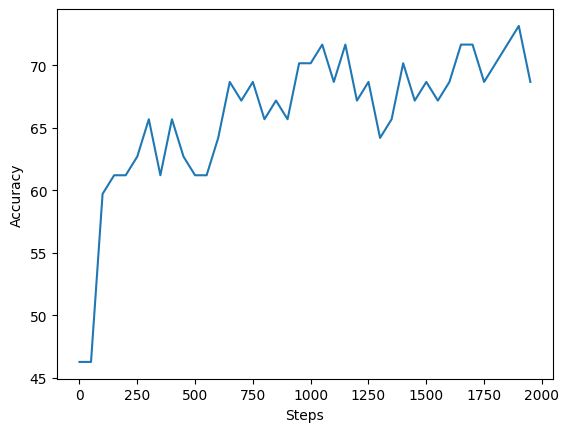

In [ ]:
neurons = 100
image_vector_size = 400*400*3
output_size = 2 #2 possibilities
params = [0,0,0,0]
params[0] = 0.1*np.random.randn(neurons, image_vector_size)
params[1] = 0.1*np.random.randn(neurons)
params[2] = 0.1*np.random.randn(output_size,neurons)
params[3] = 0.1*np.random.randn(output_size)

entropy_grad = jit(jax.grad(jit(entropy)))
dendritic_success = []
step = []
for i in range(0,2000):
  random_brain = np.random.randint(len(training_set))
  brain = training_set[random_brain]
  gradient = entropy_grad(params, brain, training_labels[random_brain])
  for j in range(len(gradient)):
    params[j] -= (0.1/100) * gradient[j]
  if (i % 50 == 0):
    step.append(i)
    diagnosis = success(params, test_set, test_labels)
    dendritic_success.append(diagnosis)
    print("After " + str(i) + " steps, the fraction correct is " + str(diagnosis) + '%')

plt.plot(step, dendritic_success)
plt.xlabel("Steps")
plt.ylabel("Accuracy")

## **Epoch**
As you can see, our robo-doctor's diagnostic accuracy peaked at roughly 73.13%. The real doctors, when presented with MRI scans have success rates that range from 70-90% so this is pretty nice. It is also marginally better than the galaxy situation, likely due to the use of all the RGB channels and conspicuity of intercranial tumors.

Let's perform a final demonstration: We shall present our program with an arbitrary MRI of early onset Glioblastoma Multiforme (the most aggressive brain cancer: it MUST be caught early) and see what unfolds

Here's the scan:



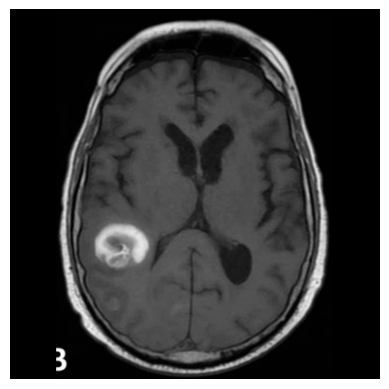

In [ ]:
from matplotlib import image as mpimg
glioblastoma = mpimg.imread("/content/gbm.jpg")
plt.imshow(glioblastoma)
plt.axis('off')
plt.show()

May the grand finale ensue...

In [ ]:

#We sneakily appended the glioblastoma scan to the end of the test set earlier. Here goes!

def neuralneural_network(params, imageVector):
   W1=params[0]
   b1=params[1]
   W2= params[2]
   b2 = params[3]
   v_in = imageVector
   v_out = 1/(1+jnp.exp(-(jnp.dot(W2,jnp.tanh(jnp.dot(W1,v_in) + b1)) +b2)))
   return v_out

gbm = np.asarray(Image.open('/content/gbm.jpg'))

multiforme = gbm.reshape(400*400*3)/256.

diagnosis = neuralneural_network(params, multiforme)


if (diagnosis[0] > diagnosis[1]):
  print("This patient is indeed suffering from an intercranial tumor")
else:
  print("This patient is not suffering from an intercranial tumor")


This patient is indeed suffering from an intercranial tumor
